In [2]:
# Usada para trabalhar com os dados
import pandas as pd

# Usada para trabalhar com datas
import datetime as dt
from datetime import timedelta

# Usada para o webscrapping (extrair os dados do site)
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup

# Bibliote para pausar o codigo
import time 

# Ignora as avisos
import warnings
warnings.filterwarnings('ignore')

# Seta configuracoes do pandas para visualizar os dados completos
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 10000
pd.options.display.max_rows = 100000

In [3]:
# Criando funcao que extrai os dados do site de vinhos
def extrai_dados_site(link, ano=None, botao=None):

    # Abre o chrome da máquina
    service = Service()
    options = webdriver.ChromeOptions()
    # Ativar o modo headless (chrome nao abre a janela enquanto executa)
    options.add_argument('--headless') 
    driver = webdriver.Chrome(service=service, options=options)

    # Acessa o site (link com a base)
    driver.get(link)

    # Caso queira que clique em um dos botoes antes de baixar a base
    if botao != None:
        driver.find_element(by='xpath', value= botao).click()

        # Aguarda a pagina atualizar    
        # time.sleep(2)
        
    if ano != None:
        # Marca o campo de ano 
        driver.find_element(by='xpath',value='//*[@id="p_ano"]/input[1]').send_keys(ano)

        # Clica no OK para buscar os dados daquele ano
        driver.find_element(by='xpath',value='/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[3]/form/p/input[2]').click()
      
    # Pega o codigo fonte da base
    page_source = driver.page_source

    # Faz a leitura do HTML da pagina para podermos trabalhar posteriormente 
    soup = BeautifulSoup(page_source, "html.parser")

    # Encontra a tabela desejada com base em suas características (classe, id, etc.) do HTML
    table = soup.find("table", class_="tb_base tb_dados")

    # Separa os titulos das bases
    headers = [header.text.strip() for header in table.find_all("th")]

    # Extrai os dados da base
    rows = []
    for row in table.find_all("tr"):
        row_data = [data.text.strip() for data in row.find_all("td")]
        if row_data:
            rows.append(row_data)

    # Cria um DataFrame com os dados
    df = pd.DataFrame(rows, columns=headers)

    # Fecha o chrome
    driver.close()

    return df

In [4]:
# Pegando os dados dos ultimos 15 anos
ano_mais_antigo = dt.date.today() - timedelta(days=15*365)
ano_mais_antigo = ano_mais_antigo.year

# Separa ano atual 
ano_atual = dt.date.today().year

In [5]:
# Listando link com os dados
link_exportacao = 'http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_06'

# Criando data frame vazio onde sera inserido os dados
df_exportacao = pd.DataFrame()

# Cada botao na página terá que processar estas quatro quebras
categorias = ['Vinhos de mesa' , 'Espumantes', 'Uvas frescas', 'Suco de uva']

# Botoes que serão clicados no site
botoes = [
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[1]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[2]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[3]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[4]',
    ]

print('Inicio:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
# Loop para empilhar os dados dentro de range de 15 anos
for ano_temp in range(ano_mais_antigo, ano_atual):
        
    for i in range(len(categorias)):
        print(f'\tProcessando ano - {categorias[i]}:', ano_temp)

        df_temp = extrai_dados_site(link_exportacao, ano_temp, botoes[i])

        df_temp['categorias'] = categorias[i]
        df_temp['ano'] = ano_temp
        
        df_exportacao = df_exportacao.append(df_temp)

print('Fim:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

df_exportacao.columns = ['paises', 'quantidade_kg','valor','categorias','ano']

df_exportacao.to_csv(
    r'bases\df_exportacao_15_anos.csv',
    index=False,
    sep=';'
)

Inicio: 19-10-2023 22:54:15
	Processando ano - Vinhos de mesa: 2020
	Processando ano - Espumantes: 2020
	Processando ano - Uvas frescas: 2020
	Processando ano - Suco de uva: 2020
	Processando ano - Vinhos de mesa: 2021
	Processando ano - Espumantes: 2021
	Processando ano - Uvas frescas: 2021
	Processando ano - Suco de uva: 2021
	Processando ano - Vinhos de mesa: 2022
	Processando ano - Espumantes: 2022
	Processando ano - Uvas frescas: 2022
	Processando ano - Suco de uva: 2022
	Processando ano - Vinhos de mesa: 2023
	Processando ano - Espumantes: 2023
	Processando ano - Uvas frescas: 2023
	Processando ano - Suco de uva: 2023
Fim: 19-10-2023 22:56:18


In [8]:
# Listando link com os dados
link_producao = 'http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_02'

# Criando data frame vazio onde sera inserido os dados
df_producao = pd.DataFrame()

print('Inicio:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
# Loop para empilhar os dados dentro de range de 15 anos
for ano_temp in range(ano_mais_antigo, ano_atual):

    print('\tProcessando ano:', ano_temp)

    df_temp = extrai_dados_site(link_producao, ano_temp)

    df_temp['ano'] = ano_temp
    
    df_producao = df_producao.append(df_temp)

print('Fim:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

# Renomeia as colunas
df_producao.columns = ['produto', 'quantidade_litro','ano']

# Exporta o arquivo
df_producao.to_csv(
    r'bases\df_producao_15_anos.csv',
    index=False,
    sep=';'
)

Inicio: 19-10-2023 22:38:23
	Processando ano: 2008
	Processando ano: 2009
	Processando ano: 2010
	Processando ano: 2011
	Processando ano: 2012
	Processando ano: 2013
	Processando ano: 2014
	Processando ano: 2015
	Processando ano: 2016
	Processando ano: 2017
	Processando ano: 2018
	Processando ano: 2019
	Processando ano: 2020
	Processando ano: 2021
	Processando ano: 2022
	Processando ano: 2023
Fim: 19-10-2023 22:40:00


In [ ]:
# Listando link com os dados
link_processamento = 'http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_03'

# Criando data frame vazio onde sera inserido os dados
df_processamento = pd.DataFrame()

# Cada botao na página terá que processar estas quatro quebras
categorias = ['Viníferas' , 'Americanas e híbridas', 'Uvas de mesa', 'Sem classificação']

# Botoes que serão clicados no site
botoes = [
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[1]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[2]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[3]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[4]',
    ]

print('Inicio:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
# Loop para empilhar os dados dentro de range de 15 anos
for ano_temp in range(ano_mais_antigo, ano_atual):
        
    for i in range(len(categorias)):
        print(f'\tProcessando ano - {categorias[i]}:', ano_temp)

        df_temp = extrai_dados_site(link_processamento, ano_temp, botoes[i])

        df_temp['categorias'] = categorias[i]
        df_temp['ano'] = ano_temp
        
        df_processamento = df_processamento.append(df_temp)

print('Fim:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

df_processamento.columns = ['cultivar', 'quantidade_kg','categorias','ano', 'sem_definicao']

df_processamento.to_csv(
    r'bases\df_processamento_15_anos.csv',
    index=False,
    sep=';'
)

In [ ]:
# Listando link com os dados
link_comercializacao = 'http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_04'

# Criando data frame vazio onde sera inserido os dados
df_comercializacao = pd.DataFrame()

print('Inicio:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
# Loop para empilhar os dados dentro de range de 15 anos
for ano_temp in range(ano_mais_antigo, ano_atual):

    print('\tProcessando ano:', ano_temp)

    df_temp = extrai_dados_site(link_comercializacao, ano_temp)

    df_temp['ano'] = ano_temp
    
    df_comercializacao = df_comercializacao.append(df_temp)

print('Fim:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

# Renomeia as colunas
df_comercializacao.columns = ['produto', 'quantidade_litro','ano']

# Exporta o arquivo
df_comercializacao.to_csv(
    r'bases\df_comercializacao_15_anos.csv',
    index=False,
    sep=';'
)

Inicio: 13-10-2023 20:14:39
	Processando ano: 2008
	Processando ano: 2009
	Processando ano: 2010
	Processando ano: 2011
	Processando ano: 2012
	Processando ano: 2013
	Processando ano: 2014
	Processando ano: 2015
	Processando ano: 2016
	Processando ano: 2017
	Processando ano: 2018
	Processando ano: 2019
	Processando ano: 2020
	Processando ano: 2021
	Processando ano: 2022
	Processando ano: 2023
Fim: 13-10-2023 20:16:05


In [ ]:
# Listando link com os dados
link_importacao = 'http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_05'

# Criando data frame vazio onde sera inserido os dados
df_importacao = pd.DataFrame()

# Cada botao na página terá que processar estas quatro quebras
categorias = ['Vinhos de mesa' , 'Espumantes', 'Uvas frescas', 'Uvas passas', 'Suco de uva']

# Botoes que serão clicados no site
botoes = [
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[1]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[2]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[3]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[4]',
        '/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[5]'
    ]

print('Inicio:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
# Loop para empilhar os dados dentro de range de 15 anos
for ano_temp in range(ano_mais_antigo, ano_atual):
        
    for i in range(len(categorias)):
        print(f'\tProcessando ano - {categorias[i]}:', ano_temp)

        df_temp = extrai_dados_site(link_importacao, ano_temp, botoes[i])

        df_temp['categorias'] = categorias[i]
        df_temp['ano'] = ano_temp
        
        df_importacao = df_importacao.append(df_temp)

print('Fim:', dt.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

df_importacao.columns = ['paises', 'quantidade_kg','valor','categorias','ano']

df_importacao.to_csv(
    r'bases\df_importacao_15_anos.csv',
    index=False,
    sep=';'
)

Inicio: 13-10-2023 20:00:14
	Processando ano - Vinhos de mesa: 2008
	Processando ano - Espumantes: 2008
	Processando ano - Uvas frescas: 2008
	Processando ano - Uvas passas: 2008
	Processando ano - Suco de uva: 2008
	Processando ano - Vinhos de mesa: 2009
	Processando ano - Espumantes: 2009
	Processando ano - Uvas frescas: 2009
	Processando ano - Uvas passas: 2009
	Processando ano - Suco de uva: 2009
	Processando ano - Vinhos de mesa: 2010
	Processando ano - Espumantes: 2010
	Processando ano - Uvas frescas: 2010
	Processando ano - Uvas passas: 2010
	Processando ano - Suco de uva: 2010
	Processando ano - Vinhos de mesa: 2011
	Processando ano - Espumantes: 2011
	Processando ano - Uvas frescas: 2011
	Processando ano - Uvas passas: 2011
	Processando ano - Suco de uva: 2011
	Processando ano - Vinhos de mesa: 2012
	Processando ano - Espumantes: 2012
	Processando ano - Uvas frescas: 2012
	Processando ano - Uvas passas: 2012
	Processando ano - Suco de uva: 2012
	Processando ano - Vinhos de mes

In [ ]:
##### VERIFICAR QUESTAO DAS QUEBRAS DOS DADOS ***** PARA CARA PAGINA TEM QUEBRAS DIFERENTES *******
# if categ == 'Viníferas':
#     driver.find_element(by='xpath',value='/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[1]').click()

# elif categ == 'Americanas e híbridas':
#     driver.find_element(by='xpath',value='/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[2]').click()

# elif categ == 'Uvas de mesa':
#     driver.find_element(by='xpath',value='/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[3]').click()

# elif categ == 'Sem classificação':
#     driver.find_element(by='xpath',value='/html/body/table[4]/tbody/tr/td[2]/div/table/tbody/tr/td[1]/form/p/button[4]').click()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


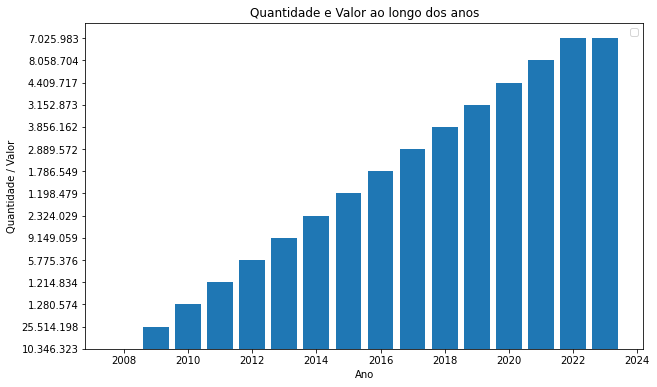

In [ ]:
# Usada para criar visões
import seaborn as sns
import matplotlib.pyplot as plt

# Criar um gráfico de linha para a coluna 'ano' em relação à coluna 'quantidade'
plt.figure(figsize=(10, 6))

# plt.plot(df_prod_total['ano'], df_prod_total['quantidade'], linestyle='-', label='Quantidade', linewidth=3)
# plt.bar(df_prod_total['ano'], df_prod_total['valor'], marker='x', linestyle='-', label='Valor')
plt.bar(df_prod_total['ano'], df_prod_total['quantidade'])
plt.title('Quantidade e Valor ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade / Valor')
# plt.grid(True)
plt.legend()

# Mostrar o gráfico
plt.show()